# Bulk Labelling as a Notebook

This notebook contains a convenient pattern to cluster and label new text data. The end-goal is to discover intents that might be used in a virtual assistant setting. This can be especially useful in an early stage and is part of the "iterate on your data"-mindset. Note that this tactic won't generate "gold" labels but it should generate something useful to help you get started. 

## Dependencies 

You'll need to install a few things to get started. 

- [whatlies](https://rasahq.github.io/whatlies/)
- [human-learn](https://koaning.github.io/human-learn/)
- [ipywidgets](https://ipywidgets.readthedocs.io/en/stable/)

You can install all tools by running this line in an empty cell; 

```python
%pip install "whatlies[all]" "human-learn" "ipywidgets"
```

Note that in order for the widgets to work you'll also need to run these commands *before* running jupyter.

```bash
jupyter nbextension enable --py widgetsnbextension
jupyter labextension install @jupyter-widgets/jupyterlab-manager
```

Next, you *should* run this notebook on port 8888. If you can't, be sure to read [this comment]]() and set a flag;

```
export BOKEH_ALLOW_WS_ORIGIN=localhost:8889
python -m jupyter lab --port 8889 --allow-websocket-origin=localhost:8889
```

We use `whatlies` to fetch embeddings and to handle the dimensionality reduction. We use `human-learn` for the interactive labelling interface. Feel free to check the documentation of both packages to learn more. 

## Let's go

To get started we'll first import a few tools.

In [26]:
import pathlib 
import numpy as np
import ipywidgets as widgets

from whatlies import EmbeddingSet 
from whatlies.transformers import Pca, Umap
from hulearn.preprocessing import InteractivePreprocessor
from hulearn.experimental.interactive import InteractiveCharts
from whatlies.language import UniversalSentenceLanguage, LaBSELanguage

In [27]:
df = pd.read_csv("twcs.csv")

In [28]:
pattern = "(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})"

In [140]:
df_orig.to_csv("xbox-support.csv", index=False)

In [29]:
import pandas as pd 

df_orig = (pd.read_csv("twcs.csv")
             .loc[lambda d: d['text'].str.contains("XboxSupport")][['text']]
             .assign(text=lambda d: d['text'].str.replace('@[A-Za-z0-9]+', ''))
             .assign(text=lambda d: d['text'].str.replace(pattern, ''))
             .drop_duplicates())
texts = list(df_orig['text'][:1000])

Next, we're going to pick the language model of interest.

In [153]:
# The language agnostic bert model works is a good starting option, also for Non-English use-cases. 
# lang = LaBSELanguage()

# The universal sentence language works well if you're dealing with English sentences.
lang = UniversalSentenceLanguage()

INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder/4'.
INFO:absl:Downloading https://tfhub.dev/google/universal-sentence-encoder/4: 170.00MB
INFO:absl:Downloading https://tfhub.dev/google/universal-sentence-encoder/4: 340.00MB
INFO:absl:Downloading https://tfhub.dev/google/universal-sentence-encoder/4: 510.00MB
INFO:absl:Downloading https://tfhub.dev/google/universal-sentence-encoder/4: 680.00MB
INFO:absl:Downloading https://tfhub.dev/google/universal-sentence-encoder/4: 850.00MB
INFO:absl:Downloaded https://tfhub.dev/google/universal-sentence-encoder/4, Total size: 987.47MB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder/4'.


In [155]:
%%time 
# This is where we prepare all of the state
embset = lang[texts]
df = embset.transform(Umap(2)).to_dataframe().reset_index()
df.columns = ['text', 'd1', 'd2']
df['label'] = ''

CPU times: user 11.8 s, sys: 1.16 s, total: 13 s
Wall time: 5.08 s


In [31]:
%%time 
# This is where we prepare all of the state
embset = lang[texts]
df = embset.transform(Umap(2)).to_dataframe().reset_index()
df.columns = ['text', 'd1', 'd2']
df['label'] = ''

CPU times: user 1min 53s, sys: 5.25 s, total: 1min 58s
Wall time: 1min 52s


In [156]:
# Here's the global state object
state = {}
state['df'] = df.copy()
state['chart'] = InteractiveCharts(df.loc[lambda d: d['label'] == ''], labels=['group'])

Loading BokehJS ...

## Showing Clusters 

The idea is that we're embedding text embeddings in a two dimensional space. For more info on the details watch [the first tutorial](https://www.youtube.com/watch?v=YsMoGd7sYMQ&t=1s&ab_channel=Rasa).

![](pipeline.png)

We'll be using Vincent's infamous [human-learn library](https://koaning.github.io/human-learn/guide/drawing-features/custom-features.html) to draw selections of 2D embeddings.

Drawing can be a bit tricky though, so pay attention. 

0. To start drawing, make sure the red ball icon is selected.
1. You'll want to double-click to start drawing. 
2. You can then click points together to form a polygon. 
3. Next you need to double-click to stop drawing. 

This allows you to draw polygons that can be used in the code below to fetch the examples that you're interested in. Once you've drawn a polygon click "show examples" to see examples of your selections and use the textbox and "add label" button to add labels.

In [157]:
pd.set_option('display.max_colwidth', -1)

def show_draw_chart(b=None):
    with out_chart:
        out_chart.clear_output()
        state['chart'].dataf = state['df'].loc[lambda d: d['label'] == '']
        state['chart'].charts = []
        state['chart'].add_chart(x='d1', y='d2', legend=False)

def show_examples(b=None):
    with out_table:
        out_table.clear_output()
        tfm = InteractivePreprocessor(json_desc=state['chart'].data())
        subset = state['df'].pipe(tfm.pandas_pipe).loc[lambda d: d['group'] != 0]
        display(subset.sample(min(15, subset.shape[0]))[['text']])

def assign_label(b=None):
    tfm = InteractivePreprocessor(json_desc=state['chart'].data())
    idx = state['df'].pipe(tfm.pandas_pipe).loc[lambda d: d['group'] != 0].index
    state['df'].iloc[idx, 3] = label_name.value
    with out_counter:
        out_counter.clear_output()
        n_lab = state['df'].loc[lambda d: d['label'] != ''].shape[0]
        print(f"{n_lab}/{state['df'].shape[0]} labelled")

def retrain_state(b=None):
    keep = list(state['df'].loc[lambda d: d['label'] == '']['text'])
    umap = Umap(2)
    new_df = EmbeddingSet(*[e for e in embset if e.name in keep]).transform(umap).to_dataframe().reset_index()
    new_df.columns = ['text', 'd1', 'd2']
    new_df['label'] = ''
    state['df'] = pd.concat([new_df, state['df'].loc[lambda d: d['label'] != '']])
    show_draw_chart(b)

out_table = widgets.Output()
out_chart = widgets.Output()
out_counter = widgets.Output()

label_name = widgets.Text("label name")

btn_examples = widgets.Button(
    description='Show Examples',
    icon='eye'
)

btn_label = widgets.Button(
    description='Add label',
    icon='check'
)

btn_retrain = widgets.Button(
    description='Retrain',
    icon='coffee'
)

btn_redraw = widgets.Button(
    description='Redraw',
    icon='check'
)

btn_examples.on_click(show_examples)
btn_label.on_click(assign_label)
btn_redraw.on_click(show_draw_chart)
btn_retrain.on_click(retrain_state)

show_draw_chart()
display(widgets.VBox([widgets.HBox([btn_retrain, btn_examples, btn_redraw]), 
                      widgets.HBox([out_chart, out_table])]), 
        label_name, 
        widgets.HBox([btn_label, out_counter]))

/Users/vincent/Development/rasalit/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


Text(value='label name')

In [168]:
intent_words = {
    "gratitude": ['thank'], 
    "technical_issue": ['overheat', 'fix', 'not switching off', 'noise'], 
    "anger": ['shit', 'suck', 'fuck', 'fvck', 'stupid'], 
    "return": ['return'], 
    "game_related": ['madden', 'fifa', 'kotor', 'creed', 'gears', 'scrabble', 
                     'dlc', 'war', 'cod', 'halo', 'minecraft', 'wolfenstein', 
                     'farcry', 'tomb raider', 'witcher', "dragon age", "mass effect", 
                     "me1", "me2", "me3", "dragon age"],
    "help": ["suggestions", "help"],
    "digital-purchase": ["dlc", "code"]
}

In [159]:
def assign_simple_intents(dataf, **kwargs):
    df_internal = dataf.assign(text=lambda d: d['text'].str.lower())
    for intent, words in kwargs.items():
        df_internal[intent] = False
        for w in words:
            df_internal[intent] = np.where(df_internal['text'].str.contains(w), True, df_internal[intent])
    return df_internal

def keep_only_one_label(dataf):
    return (dataf.loc[lambda d: d.drop(columns=['text']).sum(axis=1) == 1]
             .melt(id_vars="text", value_vars=list(intent_words.keys()), var_name='label')
             .loc[lambda d: d['value'] == True]
             .drop(columns=['value']))

ml_df = (df_orig
  .pipe(assign_simple_intents, **intent_words)
  .pipe(keep_only_one_label))

In [160]:
df_orig.shape, ml_df.shape

((26983, 1), (6353, 2))

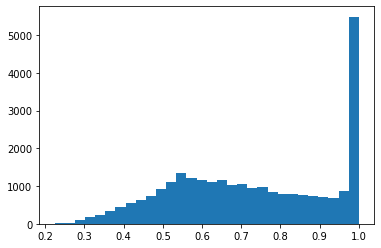

In [164]:
import matplotlib.pylab as plt
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([
    ('feats', FeatureUnion([
        ('cv1', CountVectorizer()),
    ])),
    ('mod', LogisticRegression(max_iter=1000)) 
])

ml_text = list(ml_df['text'])
probas = pipe.fit(ml_text, ml_df['label']).predict_proba(df_orig['text']).max(axis=1)
plt.hist(probas, 30);

Let's look at a couple of these examples. Can we find more words?

In [172]:
anger_examples = (df_orig
                  .loc[probas > 0.9]
                  .assign(pred = lambda d: pipe.predict(d['text']))
                  .loc[lambda d: d['pred'] == 'gratitude'])

anger_examples

,text,pred
121,"Brilliant, thank you!",gratitude
3329,"So far no, but thanks for checking in",gratitude
4739,I won a 1 month EA access subscription in your intergalactic competition the other day and I'm wondering if there's a time limit for me to redeem the code or if I'm ok to wait before entering so it's not wasted. Thanks.,gratitude
5682,Thanks RM. BluRays play fine. These DVDs also play fine on original XB1 and other devices. The discs aren’t dirty. Here’s a video. My guess is the XB1X isn’t handling some form of macrovision correctly.,gratitude
5690,"Hi JL, why thank you! I am not given an 'automatic' resolution option, unfortunately, but I set it to PC RGB and it works! The DVDs play back fine now, even with resolution still on 4K. Thank you kindly! What a champ. What is 'colour space' out of interest?",gratitude
...,...,...
2799385,Thank you I've done that and hard reset it. I let it sit for some time powered off and seems to be better now.,gratitude
2802870,"For sure. I'll let you know, thanks.",gratitude
2802887,Thanks for clarifying👍You’re doing a great job👌🏆,gratitude
2803965,"Okay, thank you so much!",gratitude


For "gratitude" I think I've found some more keywords: 

- brilliant
- great job 
- better
- for sure

In [173]:
tech_examples = (df_orig
                  .loc[probas > 0.9]
                  .assign(pred = lambda d: pipe.predict(d['text']))
                  .loc[lambda d: d['pred'] == 'technical_issue'])

tech_examples

,text,pred
233,"the 5 app on Xboxes not working error code 200, done a power cycle and still the same? Please fix app",technical_issue
1023,"I bought Dying Light from the xbox store and when I play it, it continuously freezes. I want my money back unless we can fix",technical_issue
2588,Since the latest update everytime I turn the console on I have to manually restart all downloads. When will you fix this?,technical_issue
5185,can you guys please fix the crap where I can’t join certain friends? It’s been going on ever since I started playing.,technical_issue
10413,fix the party connection.,technical_issue
...,...,...
2803991,"It's been every game. I fixed it by turning the console into offline mode, installing the game, bringing it back online then starting the patch. Cheers, but your team might like to know about the issue...",technical_issue
2807041,\nFix the dang console!! Been randomly doing this crap ALL WEEK! Can't click anything! Can't file error report! Can't Do Anything!!\n #SickOfThisCrap,technical_issue
2807048,How do I fix this? It is so large it’s running off the edge of my screen.,technical_issue
2808001,I have a problem When i enter dark souls 3 and load the game it says save data corrupted.\nPlease tell me how to fix it,technical_issue


Same thing with "tech examples". More good words; 

- error code
- patch 
- data corrupted 
- connection

In [178]:
anger_examples = (df_orig
                  .loc[probas > 0.9]
                  .assign(pred = lambda d: pipe.predict(d['text']))
                  .loc[lambda d: d['pred'] == 'digital-purchase'])

anger_examples

,text,pred


So what do we do now? Well ... we repeat until we think we've got a good recall. 

In [174]:
intent_words = {
    "gratitude": ['thank', 'brilliant', 'great job', 'better', 'for sure'], 
    "technical_issue": ['overheat', 'fix', 'not switching off', 'noise', 'error', 'patch', 'connection', 'data corrupted'], 
    "anger": ['shit', 'suck', 'fuck', 'fvck', 'stupid'], # 'fvck', 'stupid' were added
    "return": ['return', 'policy', 'refund'], # 'policy' and 'refund' added
    "game_related": ['madden', 'fifa', 'kotor', 'creed', 'gears', 'scrabble', 
                     'dlc', 'war', 'cod', 'halo', 'minecraft', 'wolfenstein', 
                     'farcry', 'tomb raider', 'witcher', "dragon age", "mass effect", 
                     "me1", "me2", "me3", "dragon age"],
    "help": ["suggestions", "help"],
    "digital-purchase": ["dlc", "code"]
}

Note that for the video games I've been using s2v instead. 

# Let's try clustering?

It's no suprise that it doesn't work very well.

In [126]:
import hdbscan
import umap

mod = hdbscan.HDBSCAN(min_cluster_size=5)

In [127]:
%%time 
X = lang.fit(texts).transform(texts)

CPU times: user 1min 41s, sys: 3.88 s, total: 1min 44s
Wall time: 1min 45s


In [128]:
mod.fit(umap.UMAP(n_components=10).fit(X).transform(X))

HDBSCAN()

In [129]:
pd.Series(mod.labels_).value_counts()

-1     586
 24    75 
 23    36 
 19    28 
 21    27 
 15    21 
 11    18 
 27    18 
 17    17 
 7     17 
 12    15 
 14    14 
 6     12 
 25    12 
 20    11 
 22    11 
 5     9  
 16    8  
 2     8  
 8     8  
 0     7  
 18    6  
 13    6  
 26    5  
 9     5  
 10    5  
 4     5  
 3     5  
 1     5  
dtype: int64

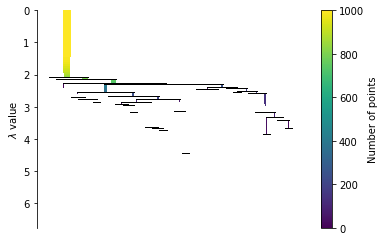

In [131]:
mod.condensed_tree_.plot()

In [137]:
for t in np.array(texts)[mod.labels_ == 23]:
    print(t)

 Maybe push them into fixing broken achievements on Xbox One?
   will be Xbox Play Anywhere title?
 I agree  is awesome! #XboxHelp
 hey I've got a question about the Xbox One X Scorpio edition.
  on the Xbox one x, and use the option HDR on my games ?
 That’s the Xbox one still use QR code’s 🤔
 Where is my patch for Xbox one
 Confusing thing is that the Xbox s controller has no issues
 why ain’t Netflix or Hulu working on y Xbox
 Xbox won’t let me leave the party
     I have that issue with my Xbox one original
 Is there anyone who can send me a new Xbox One S?
Xbox Overheated Twice In The Past 4 Minutes. 
 I need help regarding in game keyboard freezing on Xbox one
 I think something may be wrong with my Xbox maybe??
Is Xbox Live down? 
Does anyone elses #XboxOneX sound like this?  
  you on xbox as well?
 It works fine for me on Xbox One games but 360 games won’t load my profile?
 Also is it normal if my Xbox 360 E has a Xbxo 360 S hard drive?
 100k happy thanksgivings Xbox 
 hiya an